<a href="https://colab.research.google.com/github/ragul-n/Gender-bias-in-Indian-movies/blob/master/word2vec/calculating_bias_measure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U fse
!pip install --upgrade scipy 
!pip install --upgrade numpy

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
movies_data=pd.read_csv("https://github.com/ragul-n/Gender-bias-in-Indian-cinema/blob/78bc1bff5a0bd14ba94220f63d2b383d1a963df9/Data%20Collection/data/indian%20movies.csv?raw=true")
movies_data["Year"]= movies_data.Year.str.extract("(\d{4})").loc[:,0]
movies_data["Year"]=[float(i) for i in movies_data.Year]
movies_data=movies_data.set_index("ID")
movies_data.head()

,Movie Name,Year,Timing(min),Rating(10),Votes,Genre,Language
ID,,,,,,,
tt0398974,Dr. Shaitan,1960.0,-,-,-,-,hindi
tt1702558,Nadir Khan,1968.0,-,-,-,-,urdu
tt0493437,Apna Sapna Money Money,2006.0,134 min,5.3,"1,892","Comedy, Musical, Romance",hindi
tt0273405,Aag Aur Sholay,1987.0,-,2.2,20,-,urdu
tt0049595,Parivar,1956.0,-,7.4,21,"Comedy, Drama, Family",hindi


### Dictionary Generation

In [3]:
polarity= pd.read_csv("/content/drive/MyDrive/Dataset/word2vec/polarity_career_vs_family_v2.csv",index_col=0, names=["score"]).score

polarity_norm= (polarity - polarity.mean())/polarity.std()
high_polarity= polarity_norm[(polarity_norm>2) | (polarity_norm<-2)]

In [4]:
from gensim.models import KeyedVectors

word_vectors= KeyedVectors.load("/content/drive/MyDrive/Dataset/word2vec/subtitles_word_emb_v6.word_vectors")

In [5]:

target_words=['queen', 'wife', 'woman', 'ladi', 'bride', 'femal',
'goddess', 'feminin', 'she', 'sister', 'madonna',  'womanhood', 'mother','babe']

In [6]:
associated_words= []
for target_word in target_words:
    n_similar_words= word_vectors.similar_by_word(target_word, topn=100)

    for word, score in n_similar_words:
        associated_words.append(word)

In [7]:
dictionary= set(associated_words) & set(high_polarity.index)

In [8]:
dictionary_vector= np.zeros(200)

for word in dictionary:
    dictionary_vector= dictionary_vector + polarity[word]*word_vectors[word]

### Estimating Subtitle Embeddings

In [9]:
from fse.models import SIF

model= SIF.load("/content/drive/MyDrive/Dataset/word2vec/subtitles_fse.model")


In [11]:
from fse import IndexedList
import os
import tqdm 

def read_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    sents=[line.split() for line in lines]
    return sents

def angular_distance(v1, v2):
  v1_normalized = v1 / np.linalg.norm(v1)
  v2_normalized = v2 / np.linalg.norm(v2)
  return np.arccos(np.clip(np.dot(v1_normalized, v2_normalized), -1.0, 1.0))

def estimate_document_vector(sents):
    indexed_sents=IndexedList(sents)
    sents_vector= model.infer(indexed_sents)

    doc_vector= np.add.reduce(sents_vector) - model.svd_res[1][0]

    return doc_vector

folder_path='/content/drive/MyDrive/Dataset/processed_subtitles/'

distance_dict={}

for filename in tqdm.tqdm(os.listdir(folder_path)):
    sents= read_file(folder_path+filename)

    subtitle_vector = estimate_document_vector(sents)
    dis=angular_distance(dictionary_vector, subtitle_vector)
    distance_dict[filename[:9]]=dis

    

100%|██████████| 4168/4168 [01:14<00:00, 55.76it/s]


### Data Analysis

In [12]:
movies_data["distance"]=pd.Series(distance_dict)

In [13]:
data=movies_data[~ movies_data.distance.isna()].copy()
data=data[data.Language.isin(["hindi","tamil","malayalam","telugu","kannada","punjabi","bengali"])].copy()
data["normalized_distance"]=(data.distance- data.distance.min())/(data.distance.max() - data.distance.min())
#data=data[(data.Year>=2000) & (data.Year<=2019)]
data["Year"]=data.Year.astype("int64")


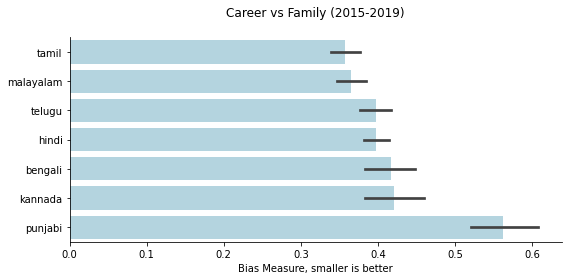

In [14]:

fig, ax= plt.subplots(figsize=(8,4))
fig.patch.set_visible(False)

ax=sns.barplot(data=data[data.Year>=2015], y="Language", x="normalized_distance",color="lightblue",
                            order=["tamil", "malayalam","telugu","hindi","bengali","kannada","punjabi"], ax=ax)

plt.xlabel("Bias Measure, smaller is better")

#ax.tick_params(left=False, labelleft=False)
# for bars_group in ax.containers:
#     ax.bar_label(bars_group, padding=3, fontsize=15)

sns.despine()
ax.set(ylabel=None, title="Career vs Family (2015-2019)\n")
plt.tight_layout()

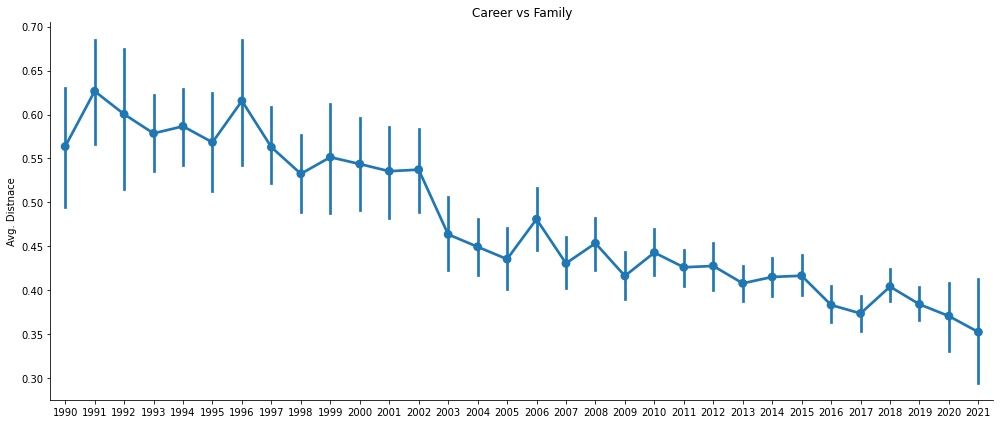

In [17]:
fig, ax= plt.subplots(figsize=(14,6))

sns.pointplot(data=data[data.Year>=1990], y="normalized_distance",x="Year", ci=95)

sns.despine()
ax.set(title="Career vs Family",xlabel=None, ylabel="Avg. Distnace")
plt.tight_layout()

In [ ]:
data[data.Year>=2015]["normalized_distance"]["tt5200962"] #tt5200962 -> kathalum kadathu pogum 

0.17278697160225598